## Elevation Data

All the elevation data collected is from the Shuttle Radar Topography Mission (STRM).

We assume a 30km x 30km square region centered on the burn zone (7°47'30" W, 37°15'0" N).

In [1]:
# https://www.bombeiros.pt/wp-content/uploads/2012/09/Relatorio-de-ocorrencia-2012080021067-Tavira_Cachopo_Catraia.pdf

# Calculate bounding box of burn zone:
# - http://edwilliams.org/gccalc.htm

# How to parse elevation data:
# - https://dds.cr.usgs.gov/srtm/version2_1/Documentation/Quickstart.pdf
# - https://librenepal.com/article/reading-srtm-data-with-python/

In [2]:
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt

LON_MIN = -7.9226975 # °W
LON_MAX = -7.6624791 # °W
LAT_MIN = 37.084652 # °N
LAT_MAX = 37.4117745 # °N
SPF = 1201 # number of samples per file
REGION_LENGTH = 30000 # defined to be 30km x 30km
CA_LENGTH = 100 # defined to be 100m
CA_SIZE = int(REGION_LENGTH / CA_LENGTH) # for a 90km^2 region, this should be 300x300

def each_coordinate():
    """ Returns each ordinate pair in the studied range with step sizes of 300m. """
    for x, lon in enumerate(np.linspace(LON_MIN, LON_MAX, CA_SIZE)):
        for y, lat in enumerate(np.linspace(LAT_MIN, LAT_MAX, CA_SIZE)):
            yield x, y, lon, lat

In [3]:
elevations = np.empty((CA_SIZE, CA_SIZE))

with open("../data/N37W007.hgt", 'rb') as data:
    # Each data point is a 2 byte big endian signed integer
    raw = np.fromfile(data, np.dtype('>i2'), SPF*SPF).reshape((SPF, SPF))

    def get_elevation(lon, lat):
        """ Retrieve the recorded elevation at the given WGS84 coordinate pair. """
        lat_row = int(round((lat - int(lat)) * (SPF - 1), 0))
        lon_row = int(round((lon - int(lon)) * (SPF - 1), 0))
        return raw[SPF - 1 - lat_row, lon_row]

    # Get the elevation data for every 100m x 100m square
    for x, y, lon, lat in each_coordinate():
        elevations[x, y] = get_elevation(abs(lon), abs(lat))

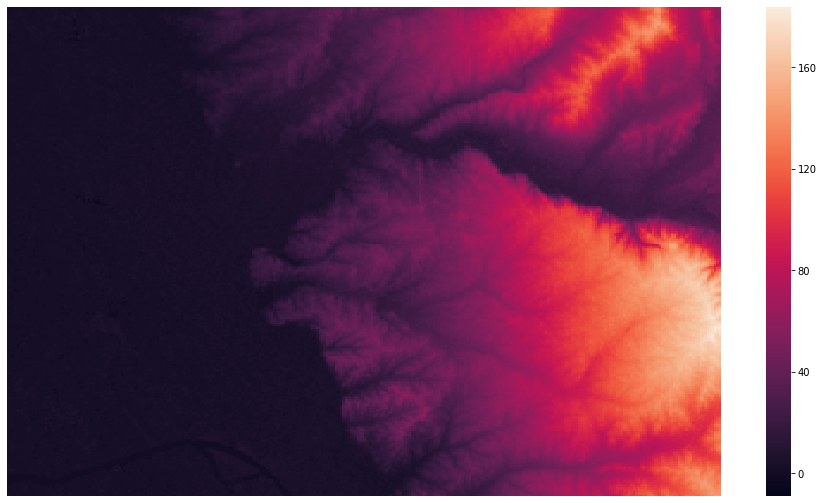

In [57]:
import seaborn as sns

plt.figure(figsize=(16, 9))
ax = sns.heatmap(elevations)
ax.invert_yaxis()
plt.axis(False)
plt.show()

---

## Vegetation Coverage Data

Vegetation type data was collected and downloaded from the CORINE Land Cover 2006 raster maps (https://land.copernicus.eu/pan-european/corine-land-cover/clc-2006).

Vegetation density data was collected and downloaded from the

In [59]:
import rasterio
import rasterio.warp

# GeoTIFF data is in EPSG:3035 - https://epsg.io/3035
# Convert lon/lat bounds from EPSG:4326 (WGS84) to EPSG:3035 with https://epsg.io/transform#s_srs=4326&t_srs=3035
AA_MIN = round(2730675.00, -2)
BB_MIN = round(1743959.99, -2)
AA_MAX = round(2760675.00, -2)
BB_MAX = round(1773959.99, -2)

veg_type = np.empty((CA_SIZE, CA_SIZE))

with rasterio.open('../data/CLC2006_V2018-20.tif') as dataset:
    # Get the first (and only) band of data from the dataset
    band = dataset.read(1)
    
    def get_vegetation_type(xlon, ylat):
        row, col = dataset.index(xlon, ylat)
        val = band[row, col]
        
        if val <= 212 or val >= 331:
            # No vegetation
            val = 0
        elif (val >= 321 and val <= 324) or val == 231:
            # Shurubland
            val = 2
        elif (val >= 213 and val <= 221) or (val >= 241 and val <= 242):
            # Agriculture
            val = 1
        elif val >= 222 and val <= 313:
            # Forests
            val = 3
        
        return val

    # Get the vegetation data for every 300m x 300m square
    for x, xlon in enumerate(np.linspace(AA_MIN, AA_MAX, CA_SIZE)):
        for y, ylat in enumerate(np.linspace(BB_MIN, BB_MAX, CA_SIZE)):
            veg_type[x, y] = get_vegetation_type(xlon, ylat)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 65000, 'height': 46000, 'count': 1, 'crs': CRS.from_dict(init='epsg:3035'), 'transform': Affine(100.0, 0.0, 900000.0,
       0.0, -100.0, 5500000.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


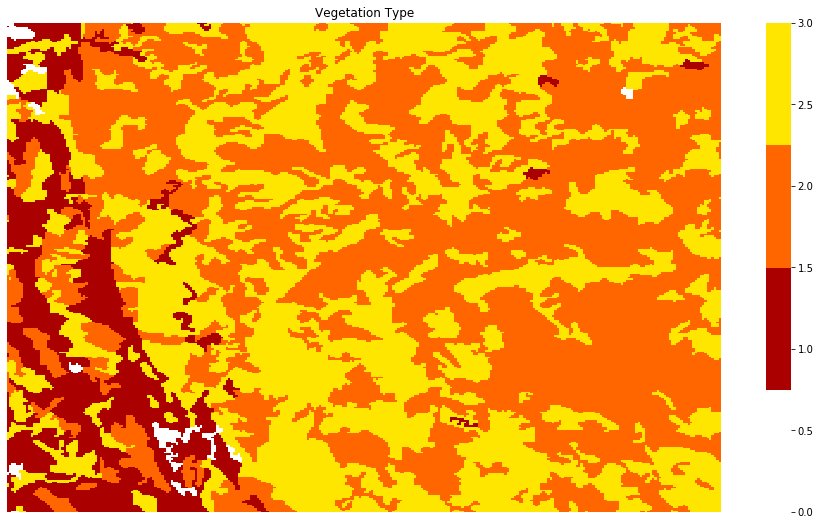

In [50]:
from matplotlib.colors import LinearSegmentedColormap

cmap_type = LinearSegmentedColormap.from_list(
    name="veg_type",
    colors=[(1, 1, 1), (170/255, 0, 0), (1, 102/255, 0), (1, 230/255, 0)],
    N=4
)

plt.figure(figsize=(16, 9))
ax = sns.heatmap(veg_type, cmap=cmap_type)
ax.invert_yaxis()
plt.axis(False)
plt.title("Vegetation Type")
plt.show()

In [62]:
veg_density = np.empty((CA_SIZE, CA_SIZE))

with rasterio.open('../data/MODIS_2001-2012.tif') as dataset:
    band = dataset.read(1)

    def get_vegetation_density(lon, lat):
        row, col = dataset.index(lon, lat)
        return band[row, col] / 100

    # Get the vegetation data for every 100m x 100m square
    for x, y, lon, lat in each_coordinate():
        veg_density[x, y] = get_vegetation_density(lon, lat)

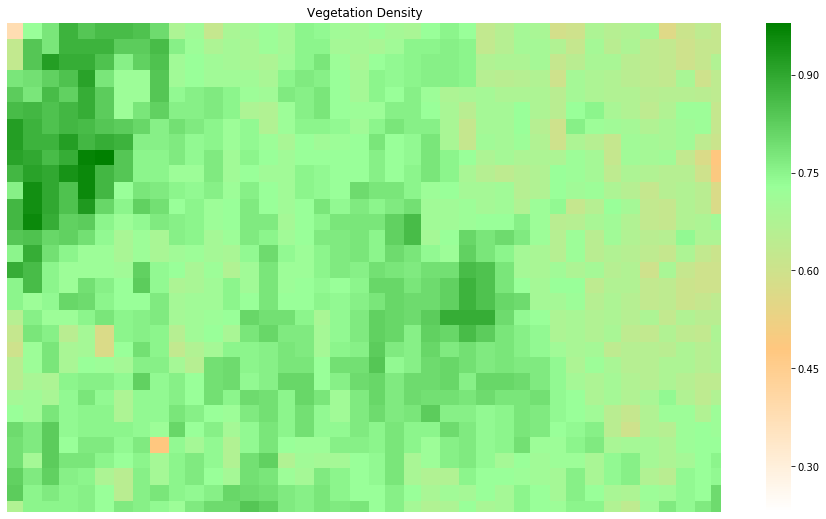

In [70]:
cmap_density = LinearSegmentedColormap.from_list(
    name="veg_density",
    colors=[(1, 1, 1), (1, 199/255, 127/255), (153/255, 1, 153/255), (0, 128/255, 0)]
#     colors=[(253/255, 253/255, 103/255), (0, 132/255, 101/255)]
)

plt.figure(figsize=(16, 9))
ax = sns.heatmap(veg_density, cmap=cmap_density)
ax.invert_yaxis()
plt.axis(False)
plt.title("Vegetation Density")
plt.show()

## Exporting the Data
For ease of use, we export the data in a compressed NumPy array format so we can easily distribute and work with it later.

In [67]:
np.savez_compressed('../data/processed.npz', elevations=elevations, vegetation_types=veg_type, vegetation_densities=veg_density)